# Toy problem : some kind of simple differentiable programming with Flux

Author: Charles Le Losq, Australian National University, 2019.

In this problem, we want a neural network to predict the parameter of a function that allows calculation of the $y$ observations.

We will use Flux.jl in Julia to approach this problem, as this library makes this kind of work very straightforward.

In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, BatchNorm, relu, Chain, ADAM, RMSProp, Descent, params, throttle, Dropout, @epochs, testmode!
using NNlib, ProgressMeter,Plots,ProgressMeter, BenchmarkTools
pyplot()

Plots.PyPlotBackend()

# The problem

$y$ depends on $x1$ and $x2$ via the equation

$y = A + \frac{B}{x2} + C\times cos(x2./D)$   eq. 1

with $A$, $B$ $C$, and $D = f(x1)$ and $f$ unknown. Here we will generate a toy dataset with a simple $f$ and $x1$ with 1 feature, but in reality $f$ is a stronly non-linear function and inputs $x1$ have multiple features.

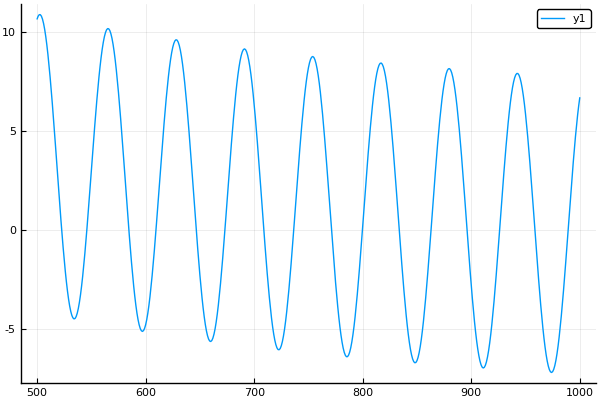

In [14]:
function model(x2,A,B,C,D) # this is eq. 1
    return A .+ B./x2 .+ C.*cos.(x2./D)
end

# here we assume we know how A, B and C vary with x1
function fake_eq0(x1)
    A = -3.0 # constant
    B = 40000.0.*0.1.*x1
    C = abs.(0.5 .- x1.*10.)
    D = 10.0
    return A, B, C, D
end

x1 = Float32.(collect(0.4:0.01:0.9))
x2 = Float32.(collect(500.:1.:1000.))


A_fake, B_fake, C_fake, D_fake = fake_eq0(x1)

# we buyild our training set
X1_training = []
X2_training = []
y_training = []

for i =1:length(B_fake)
    append!(X1_training,ones(length(x2),1)*x1[i])
    append!(X2_training,x2)
    append!(y_training,model(x2,A_fake,B_fake[i],C_fake[i],D_fake))
end

X1_training=Float32.(reshape(X1_training,1,length(X1_training)))
X2_training=Float32.(reshape(X2_training,1,length(X2_training)))
y_training=Float32.(reshape(y_training,1,length(y_training)))

plot(x2,y_training[X1_training.==Float32(0.8)]) # for one x1, we have a nice variation described by eq.1

# Solving the problem: 

Combine neural net to predict B and C, we also know that A and D are constant so we solve them at the same time, and then use this in eq .1 to predict our observations.

In [15]:
# Let's start by constructing the network and declaring the parameters for clarity

# This will be needed for proper initialization
# We need this to init the bias of the output layer not too far from the y values
# We see that we need to know somehow the magnitude of those values
# It should make sense in a real problem (we can't know nothing...)
init_f(dims) = ones(dims).*[log.(1000.);log.(10.)]

nb_neurons = 100
c1 = Flux.Dense(1, nb_neurons, relu)
c2 = Flux.Dense(nb_neurons, nb_neurons, relu)
cout= Flux.Dense(nb_neurons,2,initb=init_f)
core = Flux.Chain(c1,c2,cout)

# declaring A and D as Flux parameters
A_ = Flux.param([-1.0])
D_ = Flux.param([1.0])

# B and C should be strictly possitive, so we use the trick of Bishop to take the exp. of the output.
B_(x,network) = reshape(exp.(network(x)[1,:]),1,size(x,2))
C_(x,network) = reshape(exp.(network(x)[2,:]),1,size(x,2))

# our final prediction function
predictions(x1,x2,network,A,D) = model(x2,A,B_(x1,network),C_(x1,network), D)

# Loss function
loss(x,x2,y,network,A,D) = Flux.mse(predictions(x,x2,network,A,D),y)

loss (generic function with 1 method)

In [16]:
@time begin
    # print details before run
    println("Train loss before training $(loss(X1_training, X2_training, y_training,core,A_,D_).data)" )

    # loop details
    nb_epoch = 100

    record_loss_train = []
    evalcb = () -> (push!(record_loss_train, loss(X1_training, X2_training, y_training,core,A_,D_).data))

    for i = 1:nb_epoch
        Flux.train!(loss, params(core, A_, D_), [(X1_training, X2_training, y_training,core,A_,D_)], ADAM(0.001), cb = throttle(evalcb, 1))
    end

    println("Train loss after training $(loss(X1_training, X2_training, y_training,core,A_,D_).data)" )
end

Train loss before training 69.07773588155061
Train loss after training 19.775741450672754
162.812785 seconds (881.50 M allocations: 62.465 GiB, 13.66% gc time)


In [5]:
println("Test loss after training $(loss(X1_training, X2_training, y_training,core,A_,D_).data)" )
plot(record_loss_train)

Test loss before training 58.83240045916165


UndefVarError: UndefVarError: record_loss_train not defined

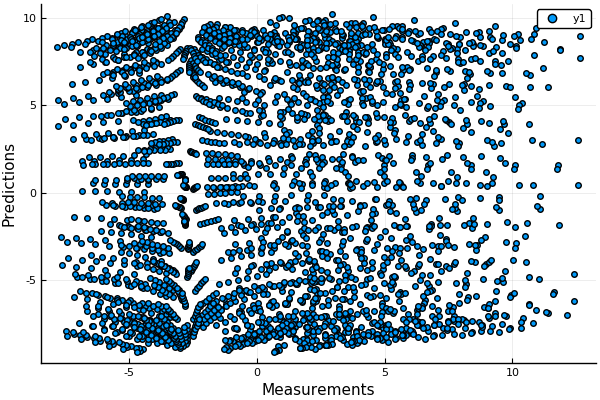

In [6]:
y_preds = predictions(X1_training,X2_training,core,A_,D_).data

scatter(y_training',y_preds',xlabel="Measurements", ylabel="Predictions")

In [9]:
D_

Tracked 1-element Array{Float64,1}:
 0.9980398764270245